# Text Recognition (OCR) on Natural Images

Text Recognition is the process of identifying what is written in an image. It is also known as Optical Character Recognition. In our case, we are looking at a more specific case of text recognition in Natural Scene images.

The detected Text from the text detectors discussed earlier is passed to the text recognizer system and it predicts the text from the text boxes. We will be using the CRNN based model for recognizing text.

[An End-to-End Trainable Neural Network for Image-based Sequence
Recognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717.pdf)

One thing to note is that this CRNN based Text Recognition model works for cropped text inputs and not on whole sentences/paragraphs. This model is specially useful for natural scenes like traffic signs/boards or ID Cards or number plates that consists of individual words.


<hr style="border:2px solid gray"> </hr>

## Goal

## $~~~~~~~~~~~~~~~~~~~~$Input$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$Output
<br>
<center>
<img src='https://opencv.org/wp-content/uploads/2021/10/c0-m19-demo-ocr.png' alt="Demo OCR">
</center>
<br>

In [1]:
if 'google.colab' in str(get_ipython()):
    print("Downloading Code to Colab Environment")
    !wget https://www.dropbox.com/sh/2am8d2yn4xrzk9i/AAAiJEQuwzAysEe6jNUGuCH4a?dl=1 -O module-code.zip -q --show-progress
    !unzip -qq module-code.zip
    !pip install --upgrade opencv-contrib-python
else:
    pass

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

plt.rcParams['image.cmap'] = 'gray'

# 1. Prepare for text recognition

## 1.1 Load Sample Image
Let us load a sample image and display it. We will continue to use this Dutch traffic sign.

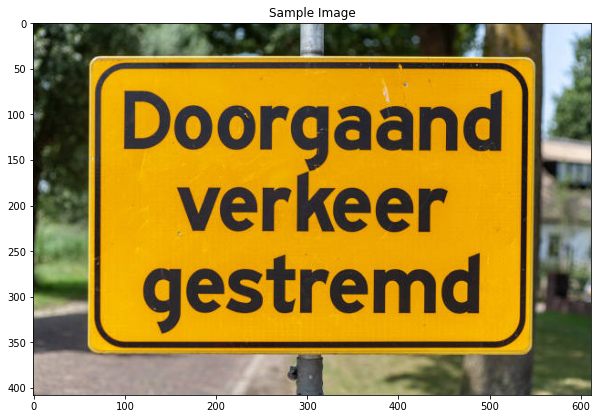

In [3]:
# Load Image
image = cv2.imread('./visuals/dutch_signboard.jpg')

# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(image[:, :, ::-1]); plt.title('Sample Image');

## 1.2 Import the Language Vocabulary to be used for the text recognition

The detected text in the image is converted into text data using this vocabulary as reference.

In [4]:
# Define list to store the vocabulary, the recognizable characters.
vocabulary =[]

# Open file to import the vocabulary.
with open("./resources/alphabet_94.txt") as f:
    # Read the file line by line, and append each into the vocabulary list.
    for l in f:
        vocabulary.append(l.strip())
    f.close()
print("Vocabulary:", vocabulary)
print("Vocabulary size: ", len(vocabulary))

Vocabulary: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']
Vocabulary size:  94


## 1.3 Import the pre-built text Detection model files

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font color="green">OpenCV Documentation</font>

For the text detection in the image, we will be using the DB based text detection deep learning neural network model covered in the previous notebook. 

[**`DB Text Detection Model()`**](https://docs.opencv.org/master/db/d0f/classcv_1_1dnn_1_1TextDetectionModel__DB.html)

In [5]:
# DB model for text-detection based on resnet50.
textDetector = cv2.dnn_TextDetectionModel_DB("./resources/DB_TD500_resnet50.onnx")

inputSize = (640, 640)

# Set threshold for Binary Map creation and polygon detection.
binThresh = 0.3
polyThresh = 0.5

mean = (122.67891434, 116.66876762, 104.00698793)

textDetector.setBinaryThreshold(binThresh).setPolygonThreshold(polyThresh)
textDetector.setInputParams(1.0/255, inputSize, mean, True)

## 1.4 Import the pre-built Recognition model files

For the text recognizer we will be using a CRNN based deep learning model that is trained on 2 datasets: 

* MJsynth 
* SynthText

It can identify all characters used in the english language, along with punctuation, matching the 94-character vocabulary imported above. We can use the already defined OpenCV function below to load and run inferences using the model.

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font color="green">Function Syntax</font>

The function can be constructed two ways:

```python
network = cv2.dnn_TextRecognitionModel(network)
network = cv2.dnn_TextRecognitionModel(model[, config])
```

The first signature has **1 required argument**:

1. `network`: Net object.

The second signature uses **2 required arguments**:

1. `model`: Binary file contains trained weights.
2. `config`: Text file contains network configuration.


### <font color="green">OpenCV Documentation</font>


[**`Text Recognition Model()`**](https://docs.opencv.org/4.5.2/de/dee/classcv_1_1dnn_1_1TextRecognitionModel.html)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

In [6]:
# CRNN model for text-recognition.
textRecognizer = cv2.dnn_TextRecognitionModel("./resources/crnn_cs.onnx")
textRecognizer.setDecodeType("CTC-greedy")
textRecognizer.setVocabulary(vocabulary)
textRecognizer.setInputParams(1/127.5, (100,32), (127.5, 127.5, 127.5), True)

# 2. Perform scene text detection

## 2.1 Use DB text detector on the image

The alraedy initialized DB text detector is applied on the input image to detect text. Vertices of bounding boxes of roi containing text and its confusion matrix is given as output to the function.

In [7]:
# Use the DB text detector initialized previously to detect the presence of text in the image.
boxes, confs = textDetector.detect(image)

## 2.2 Draw the detected bounding boxes on original image

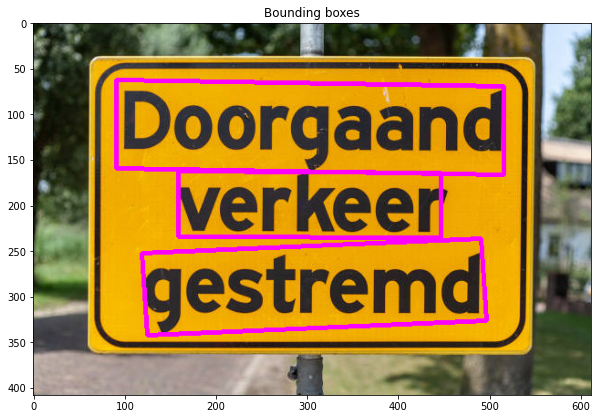

In [8]:
# Draw the bounding boxes of text detected.
cv2.polylines(image, boxes, True, (255, 0, 255), 4)
# Display the image with the bounding boxes drawn
plt.figure(figsize=(10, 8))
plt.imshow(image[:, :, ::-1]); plt.title('Bounding boxes');

## 2.3 Align Text Boxes

Geometric image transformation functions are used to align the text boxes horizontally by applying perspective transform on the roi boxes detected. This will help the text recognizer to identify the characters better.


<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font color="green">Function Syntax</font>

```python
dst = getPerspectiveTransform(src, dst[, solveMethod])
```

The function has **2 required arguments**:

1. `src`: Coordinates of quadrangle vertices in the source image.
2. `dst`: Coordinates of the corresponding quadrangle vertices in the destination image.
3. `solveMethod`: Optional argument to specify how to solve perspective, default is DECOMP_LU



```python
dst = cv.warpPerspective(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]])
```

The function has **3 required arguments** and more optional flags:

1. `src`: Input image.
2. `M`: 3×3  transformation matrix.
3. `dsize`: size of the output image.

### <font color="green">OpenCV Documentation</font>

[**`getPerspectiveTransform() `**](https://docs.opencv.org/4.5.2/da/d54/group__imgproc__transform.html#ga20f62aa3235d869c9956436c870893ae)

[**`warpPerspective()`**](https://docs.opencv.org/4.5.2/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

In [9]:
def fourPointsTransform(frame, vertices):
    """Extracts and transforms roi of frame defined by vertices into a rectangle."""
    # Get vertices of each bounding box 
    vertices = np.asarray(vertices).astype(np.float32)
    outputSize = (100, 32)
    targetVertices = np.array([
        [0, outputSize[1] - 1],
        [0, 0],
        [outputSize[0] - 1, 0],
        [outputSize[0] - 1, outputSize[1] - 1]], dtype="float32")
    # Apply perspective transform
    rotationMatrix = cv2.getPerspectiveTransform(vertices, targetVertices)
    result = cv2.warpPerspective(frame, rotationMatrix, outputSize)
    return result

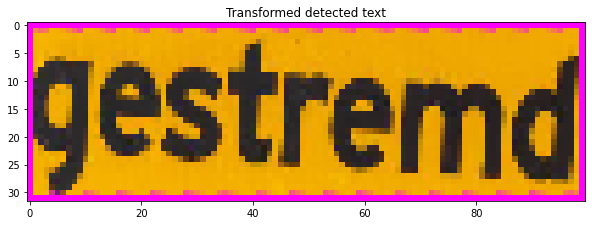

In [10]:
# Display the transformed output of the first detected text box.
warped_detection = fourPointsTransform(image, boxes[0])
plt.figure(figsize=(10, 8))
plt.imshow(warped_detection[:, :, ::-1]); plt.title('Transformed detected text');

# 3. Recognize text from each box and display on a canvas

The recognition is done for each text box. But before we pass on the text box to the recognizer, we align the box using the function defined above.

We then pass the bounding box containing text to the recognizer and get the result.

Finally, we also display the detected and recognized text in the same position where it was detected. For this, we create a blank canvas and use the location of the bounding boxes to print the text using the putText function.

Recognized Text:
gestremd verkeer Doorgaand


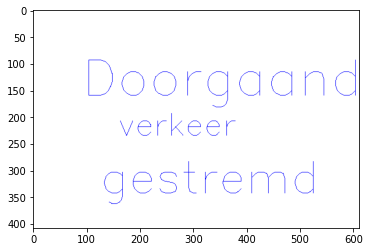

In [11]:
textData=[]
outputCanvas = np.full(image.shape[:3], 255, dtype=np.uint8)

# Iterate throught the bounding boxes detected by the text detector model
print("Recognized Text:")
for box in boxes:
    # Apply transformation on the bounding box detected by the text detection algorithm
    croppedRoi  = fourPointsTransform(image,box)
    
    # Recognise the text using the crnn model
    recResult = textRecognizer.recognize(croppedRoi)
    
    # Get scaled values
    boxHeight = int((abs((box[0, 1] - box[1, 1]))))
    
    # Get scale of the font
    fontScale = cv2.getFontScaleFromHeight(cv2.FONT_HERSHEY_SIMPLEX, boxHeight-30, 1 )
    
    # Write the recognized text on the output image
    placement = (int(box[0, 0]), int(box[0, 1]))
    cv2.putText(outputCanvas, recResult, placement,
                cv2.FONT_HERSHEY_SIMPLEX, fontScale, (255, 0, 0), 1, 5)
    # Append recognized text to the data storage variable
    textData.append(recResult)

# Join the text data together to form a output sentence
textData = ' '.join(textData)
print(textData);
plt.imshow(outputCanvas[:, :, ::-1]);

## 3.1 Concatenate input and output images and display the output together

The input and output images are concatenated together to get a nice comparative view of the process.

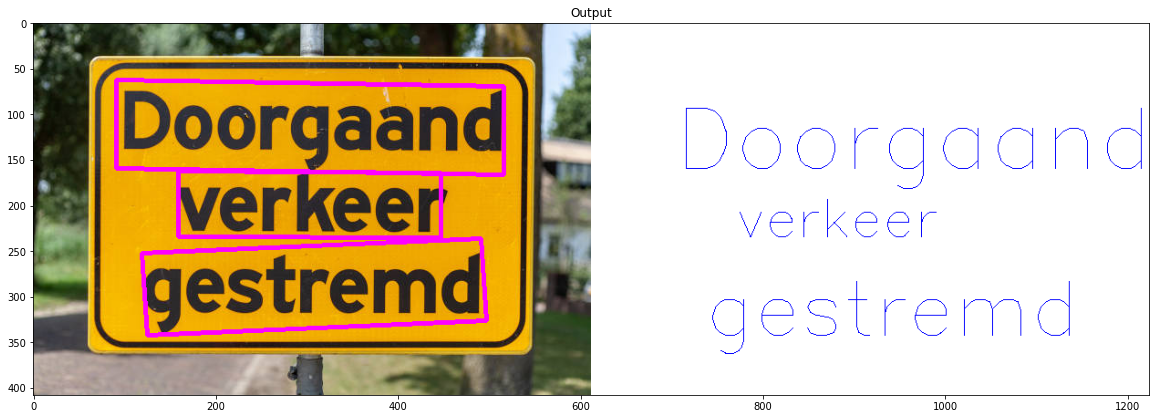

In [12]:
# Concatenate the input image with the output image
combinedResult = cv2.hconcat([image, outputCanvas])
cv2.imwrite('visuals/english_signboard_recognised.jpg', combinedResult)
# Display the output Image
plt.figure(figsize=(20, 10))
plt.imshow(combinedResult[:, :, ::-1]); plt.title('Output');

# 4. Combining it all together

In [13]:
def recognizeText(image, debug=False):
    """Detect, recognize, and output text from a natural image scene."""
    # Create a blank matrix to be used to display the output image
    outputCanvas = np.full(image.shape[:3], 255, dtype=np.uint8)

    # Use the DB text detector initialised previously to detect the presence of text in the image
    boxes, confs = textDetector.detect(image)

    print("Recognized Text:")
    # Iterate throught the bounding boxes detected by the text detector model
    for box in boxes:
        # Apply transformation on the bounding box detected by the text detection algorithm.
        croppedRoi = fourPointsTransform(image, box)
        if debug:
            plt.imshow(croppedRoi)
            plt.show()

        # Recognise the text using the crnn model.
        recResult = textRecognizer.recognize(croppedRoi)
        print(recResult)

        # Get scaled values.
        boxHeight = int((abs((box[0, 1] - box[1, 1]))))

        # Get scale of the font.
        fontScale = cv2.getFontScaleFromHeight(
            cv2.FONT_HERSHEY_SIMPLEX, boxHeight-10, 1)

        # Write the recognized text on the output image.
        placement = (int(box[0,0]), int(box[0,1]))
        cv2.putText(outputCanvas, recResult, placement,
                    cv2.FONT_HERSHEY_SIMPLEX, fontScale, (255, 0, 0), 1, 5)

    # Draw the bounding boxes of text detected.
    cv2.polylines(image, boxes, True, (255, 0, 255), 4)

    # Concatenate the input image with the output image.
    combinedResult = cv2.hconcat([image, outputCanvas])

    # Display the output Image.
    plt.figure(figsize=(20, 10))
    plt.imshow(combinedResult[:, :, ::-1]); plt.title('Output')

Recognized Text:
SELFISH
ISN'T
CARE
SELF


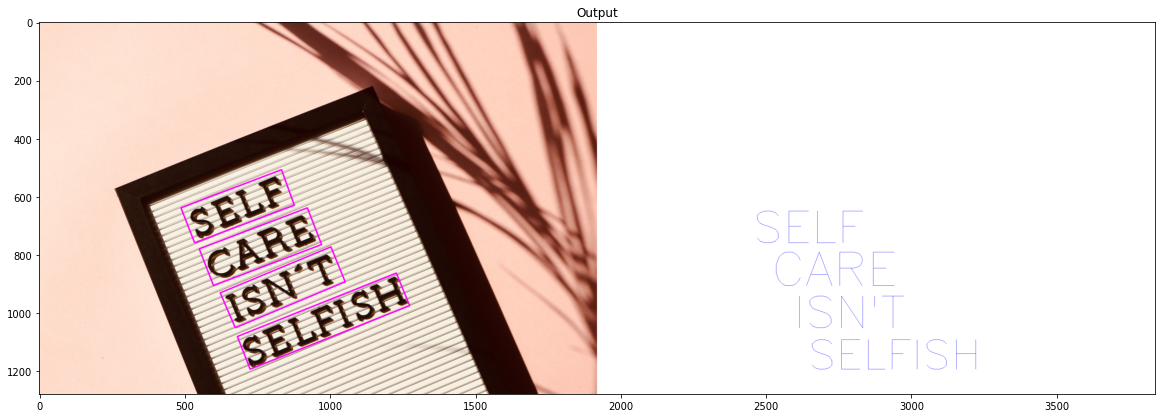

In [14]:
img2 = cv2.imread('./visuals/card.jpg')
recognizeText(img2)

Recognized Text:
SYDNEY
TOKYO
PARIS
ZURICH
VENNA
ROME
1-Pbs/@uom.ans.com
ost
D
AMSTERDAM
TORONTO
BARCELONA
PRAGUE


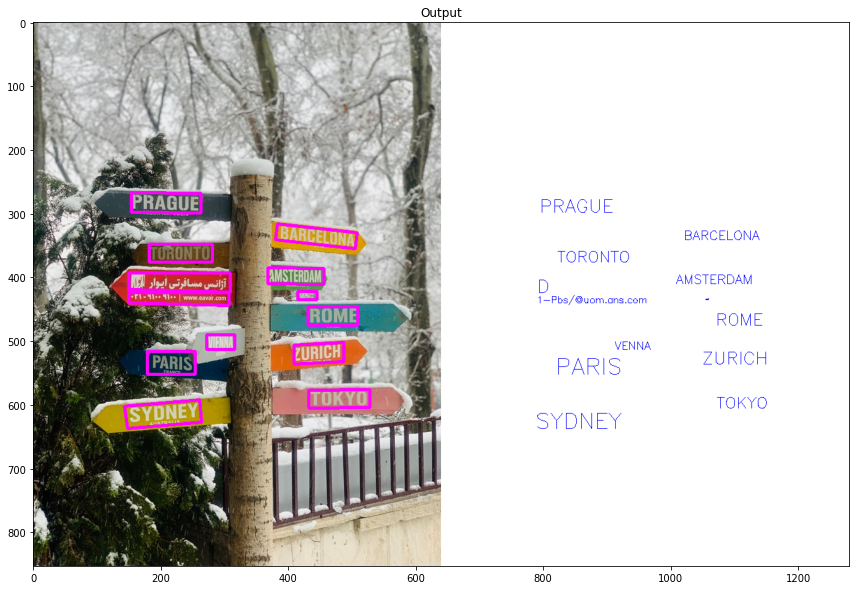

In [15]:
img3 = cv2.imread('./visuals/traffic2.jpg')
recognizeText(img3)

Recognized Text:
8272.HYX


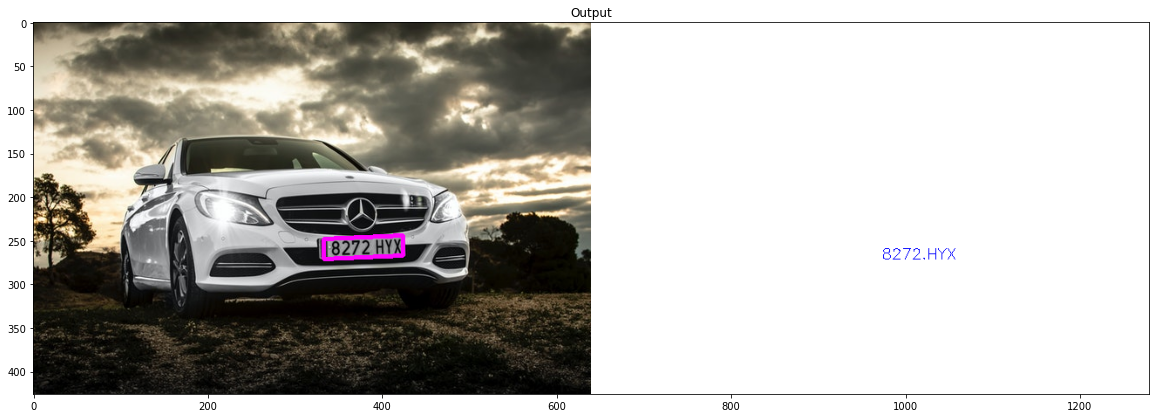

In [16]:
img4 = cv2.imread('./visuals/car.jpg')
recognizeText(img4)

Recognized Text:
TO-CROSS
PUSHBUTTON
DONTCROSS
STEAOY
mue
bo-fimish-Crossing
TIME-REMAINING
lt-Started
Finish_Crossing
DONTSTART
Vehicles
Watch-For
X
START.CROSSING


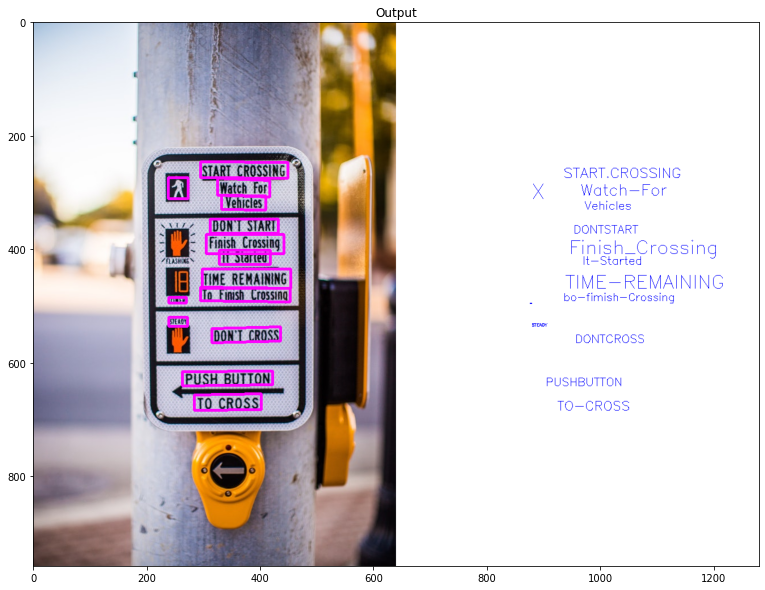

In [17]:
img5 = cv2.imread('./visuals/traffic1.jpg')
recognizeText(img5)

## 4.1 Failure Case

In case the cropped text boxes are too long, then the recognizer does not do a good job. This is because it was trained using 32x100 text boxes. So, you can imagine what happens when a long text is resized to a dimension of 32x100. take a look at this example:

Recognized Text:
AATineSEL
Tunertall
repican
Usenewell


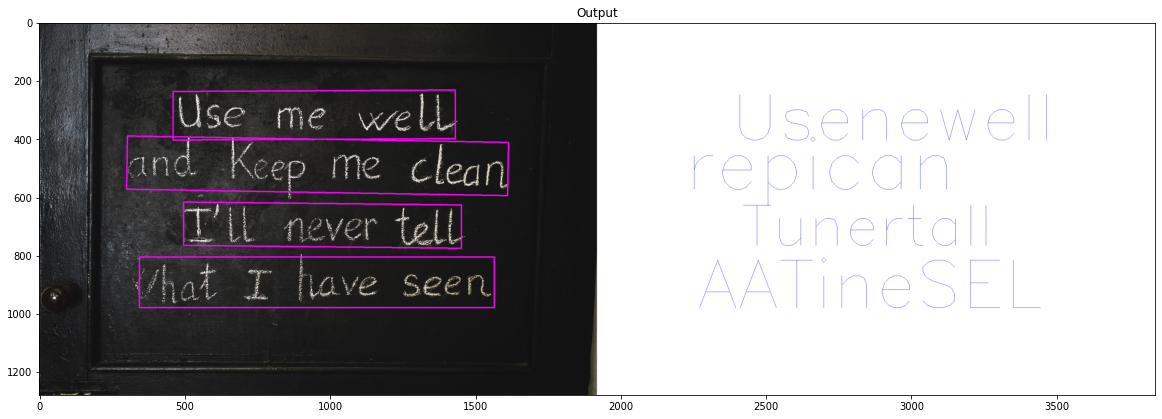

In [18]:
img6 = cv2.imread('./visuals/Board.jpg')
recognizeText(img6)

Let us chek out what's happening under the hood. We will display the detected and cropped text boxes along with what the recognizer decodes from the text box.

Recognized Text:


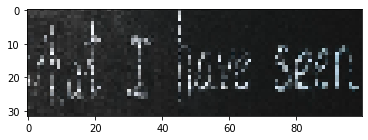

AATineSEL


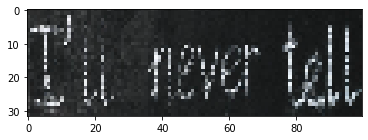

Tunertall


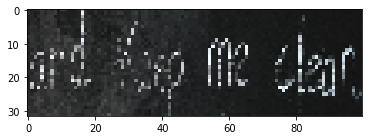

repican


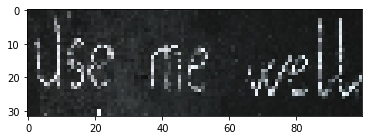

Usenewell


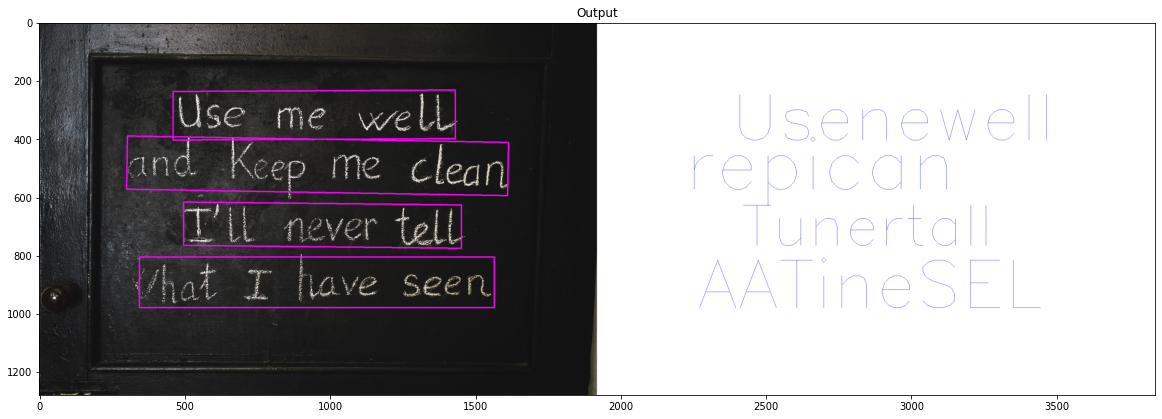

In [19]:
img6 = cv2.imread('./visuals/Board.jpg')
recognizeText(img6, debug=True)


# Conslusion

Text detection and text recognition are two stages in the overall pipeline to read words from an image. Text *detection* is here done using a DB text detection model, while text *recognition* is done using a CRNN deep learning model.

The approach shown above works pretty well for natural scene text. However, for doing OCR on other types of text like computer generated documents, there are other tools available such as Tesseract and EASYOCR that are better tailored to that use case. You should check them out:

[Tesseract](https://pypi.org/project/pytesseract)

[EasyOCR](https://github.com/JaidedAI/EasyOCR)